In [36]:
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from pandas import to_datetime
from matplotlib import pyplot as plt
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
import seaborn as sns
from sklearn.model_selection import ParameterGrid

In [37]:
#prepare the data

df = pd.read_csv('data/univariate/kenya/ken_u5_mortality.csv')
df.head(10)

,ds,y
0,1952-12-31,300.0374
1,1953-12-31,283.9339
2,1954-12-31,268.4150
3,1955-12-31,254.0990
4,1956-12-31,240.8236
5,1957-12-31,228.6289
6,1958-12-31,217.4429
7,1959-12-31,207.2148
8,1960-12-31,198.1244
9,1961-12-31,190.0339


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


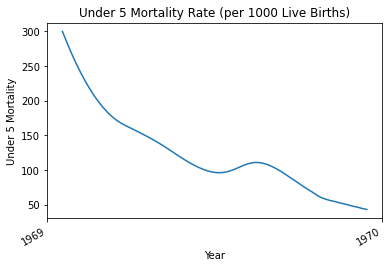

In [38]:
#visualize csv data
fig, ax = plt.subplots()
ax.plot(df['ds'],df['y'])

#transform the ticks (dates) ----- picked directly from matplotlib
# Major ticks every 6 months.
fmt_year = mdates.MonthLocator(interval = 60)
ax.xaxis.set_major_locator(fmt_year)

# Text in the x axis will be displayed in 'YYYY' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Rotates and right aligns the x labels, and moves the bottom of the axes up to make room for them.
fig.autofmt_xdate()
plt.xlabel('Year')
plt.ylabel('Under 5 Mortality')
plt.title('Under 5 Mortality Rate (per 1000 Live Births)')
plt.show()


In [39]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [40]:
#convert the dates to a datetimestring
df['ds']= to_datetime(df['ds'])

#define and fit the model
m= Prophet()
m.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:prophet:Making 10 forecasts with cutoffs between 1974-08-24 00:00:00 and 2018-12-31 00:00:00


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 16.
INFO:prophet:n_changepoints greater than number of observations. Using 20.
INFO:prophet:n_changepoints greater than number of observations. Using 24.


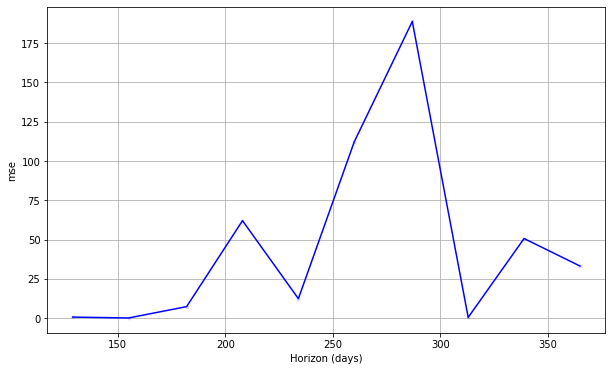

In [41]:
#check model perfomance using cross validation
#not sure how this works with little data

#create a custom cutoff date
cutoffs = pd.to_datetime(['1980-12-21','1990-12-21','2000-12-21'])

df_cv = cross_validation(m, initial='7300 days', period='1800 days', horizon = '365 days')

df_p = performance_metrics(df_cv)
df_p.head()

fig = plot_cross_validation_metric(df_cv, metric='mse')


In [42]:
#predict

#prepare the future dates
future = m.make_future_dataframe(freq = 'Y', periods=10)

forecast = m.predict(future)
forecast[['ds','yhat']].tail(10)

,ds,yhat
68,2020-12-31,37.405641
69,2021-12-31,34.794367
70,2022-12-31,32.345784
71,2023-12-31,30.057782
72,2024-12-31,27.631311
73,2025-12-31,25.020037
74,2026-12-31,22.571454
75,2027-12-31,20.283452
76,2028-12-31,17.856981
77,2029-12-31,15.245707


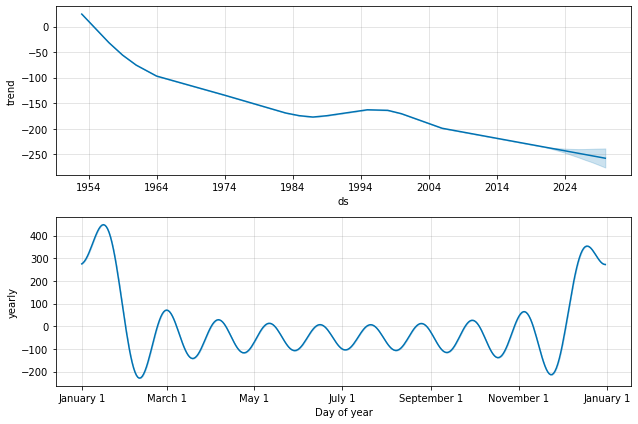

In [43]:
# Plot the components of the model
fig = m.plot_components(forecast)

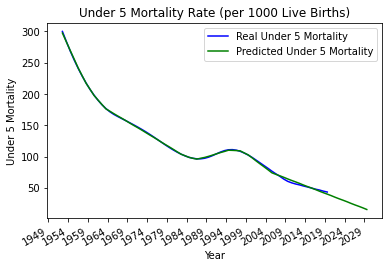

In [44]:
#visualize
# predicted = m.plot(forecast)

fig, ax = plt.subplots()
ax.plot(df['ds'],df['y'], color = 'blue', label = 'Real Under 5 Mortality')
ax.plot(forecast['ds'],forecast['yhat'], color = 'green', label = 'Predicted Under 5 Mortality')

# Major ticks every 6 months.
fmt_year = mdates.MonthLocator(interval = 60)
ax.xaxis.set_major_locator(fmt_year)

# Text in the x axis will be displayed in 'YYYY' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Rotates and right aligns the x labels, and moves the bottom of the axes up to make room for them.
fig.autofmt_xdate()
plt.xlabel('Year')
plt.legend()
plt.ylabel('Under 5 Mortality')
plt.title('Under 5 Mortality Rate (per 1000 Live Births)')
plt.show()

In [ ]:
mape = mean_absolute_percentage_error(df['y'],forecast.loc[10:, 'yhat'])
print("MAPE",round(mape,4))


                    -----Start Hyperparameter Tuning-----

In [46]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'n_changepoints' : [10,15,20],
    'seasonality_mode':('multiplicative','additive')
}


grid = ParameterGrid(param_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)


Total Possible Models 96


In [47]:

model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
for p in grid:
    test = pd.DataFrame()
    print(p)
#     random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         seasonality_prior_scale = p['seasonality_prior_scale'],
                         seasonality_mode = p['seasonality_mode'],
                         n_changepoints = p['n_changepoints'],
#                          yearly_seasonality = True,
#                          interval_width=0.
                        )
#     train_model.add_country_holidays(country_name='US')
    train_model.fit(df)
    train_forecast = train_model.make_future_dataframe(periods=10, freq='Y')
    train_forecast = train_model.predict(train_forecast)
    test=train_forecast[['ds','yhat']]
#     Actual = df[(df['ds']>strt) & (df['ds']<=end)]
    MAPE = mean_absolute_percentage_error(df['y'],abs(test.loc[:67, 'yhat']))
    print('Mean Absolute Percentage Error(MAPE)------------------------------------',MAPE)
    model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


{'changepoint_prior_scale': 0.001, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 14.887294669280482
{'changepoint_prior_scale': 0.001, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 14.972971502402252
{'changepoint_prior_scale': 0.001, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 14.778235274577053
{'changepoint_prior_scale': 0.001, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 14.852095884405056
{'changepoint_prior_scale': 0.001, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 14.414333720295117
{'changepoint_prior_scale': 0.001, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 15.117844738851579
{'changepoint_prior_scale': 0.001, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 14.99062577493172
{'changepoint_prior_scale': 0.001, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 15.084207388444035
{'changepoint_prior_scale': 0.001, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 14.885500068660631
{'changepoint_prior_scale': 0.001, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 14.915851429954447
{'changepoint_prior_scale': 0.001, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 14.764549992204417
{'changepoint_prior_scale': 0.001, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 14.576932071044594
{'changepoint_prior_scale': 0.001, 'n_changepoints': 15, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 14.980634242563045
{'changepoint_prior_scale': 0.001, 'n_changepoints': 15, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 15.117957057841327
{'changepoint_prior_scale': 0.001, 'n_changepoints': 15, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 14.987336461785139
{'changepoint_prior_scale': 0.001, 'n_changepoints': 15, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 14.984776559892833
{'changepoint_prior_scale': 0.001, 'n_changepoints': 20, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 14.884154206182416
{'changepoint_prior_scale': 0.001, 'n_changepoints': 20, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 14.912316363454453
{'changepoint_prior_scale': 0.001, 'n_changepoints': 20, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 14.76583829884181
{'changepoint_prior_scale': 0.001, 'n_changepoints': 20, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 14.572333735915063
{'changepoint_prior_scale': 0.001, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 14.973026018314734
{'changepoint_prior_scale': 0.001, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 15.111468430479945
{'changepoint_prior_scale': 0.001, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 14.98279742037188
{'changepoint_prior_scale': 0.001, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 14.985313096050493
{'changepoint_prior_scale': 0.01, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 14.757125979248343
{'changepoint_prior_scale': 0.01, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 14.983913839373347
{'changepoint_prior_scale': 0.01, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 14.951073769970998
{'changepoint_prior_scale': 0.01, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 14.967487211921679
{'changepoint_prior_scale': 0.01, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 14.997687398939103
{'changepoint_prior_scale': 0.01, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 15.063897146745632
{'changepoint_prior_scale': 0.01, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 15.044820422462408
{'changepoint_prior_scale': 0.01, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 14.962133632441226
{'changepoint_prior_scale': 0.01, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 14.987537500882112
{'changepoint_prior_scale': 0.01, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 14.990673651735381
{'changepoint_prior_scale': 0.01, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 14.946347964859758
{'changepoint_prior_scale': 0.01, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 14.940559399751887
{'changepoint_prior_scale': 0.01, 'n_changepoints': 15, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 14.999974183469888
{'changepoint_prior_scale': 0.01, 'n_changepoints': 15, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 15.104289221980661
{'changepoint_prior_scale': 0.01, 'n_changepoints': 15, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 14.970791093082411
{'changepoint_prior_scale': 0.01, 'n_changepoints': 15, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 14.968501408631617
{'changepoint_prior_scale': 0.01, 'n_changepoints': 20, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 15.078774328524371
{'changepoint_prior_scale': 0.01, 'n_changepoints': 20, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 15.002150522413638
{'changepoint_prior_scale': 0.01, 'n_changepoints': 20, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 14.940732224374315
{'changepoint_prior_scale': 0.01, 'n_changepoints': 20, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 15.022189269121853
{'changepoint_prior_scale': 0.01, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 14.983999023578571
{'changepoint_prior_scale': 0.01, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 15.199455046264045
{'changepoint_prior_scale': 0.01, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 15.186750348775227
{'changepoint_prior_scale': 0.01, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 14.982599553350951
{'changepoint_prior_scale': 0.1, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.2683201352451343
{'changepoint_prior_scale': 0.1, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.2258725648687137
{'changepoint_prior_scale': 0.1, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.217480037994084
{'changepoint_prior_scale': 0.1, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.216114159968583
{'changepoint_prior_scale': 0.1, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.2770886803208252
{'changepoint_prior_scale': 0.1, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.2761857707962847
{'changepoint_prior_scale': 0.1, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.2740494946266618
{'changepoint_prior_scale': 0.1, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.2748683339556075
{'changepoint_prior_scale': 0.1, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.0978266987024734
{'changepoint_prior_scale': 0.1, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.0594166131154252
{'changepoint_prior_scale': 0.1, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.0398842286935355
{'changepoint_prior_scale': 0.1, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.0360558808302076
{'changepoint_prior_scale': 0.1, 'n_changepoints': 15, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.1072136713113703
{'changepoint_prior_scale': 0.1, 'n_changepoints': 15, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.1046011719681263
{'changepoint_prior_scale': 0.1, 'n_changepoints': 15, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.0966410684782388
{'changepoint_prior_scale': 0.1, 'n_changepoints': 15, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.097389447479393
{'changepoint_prior_scale': 0.1, 'n_changepoints': 20, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.0183397659837239
{'changepoint_prior_scale': 0.1, 'n_changepoints': 20, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.963557670547742
{'changepoint_prior_scale': 0.1, 'n_changepoints': 20, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.9313630533543961
{'changepoint_prior_scale': 0.1, 'n_changepoints': 20, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.9234659580345543
{'changepoint_prior_scale': 0.1, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.0313395572444166
{'changepoint_prior_scale': 0.1, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.0314159908644027
{'changepoint_prior_scale': 0.1, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.0306400528917947
{'changepoint_prior_scale': 0.1, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.031042078232801
{'changepoint_prior_scale': 0.5, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.2157865035139188
{'changepoint_prior_scale': 0.5, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.2159297678116907
{'changepoint_prior_scale': 0.5, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.215686201295079
{'changepoint_prior_scale': 0.5, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.2154437754489407
{'changepoint_prior_scale': 0.5, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.2172254505900217
{'changepoint_prior_scale': 0.5, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.2170825791766997
{'changepoint_prior_scale': 0.5, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.2156118388781394
{'changepoint_prior_scale': 0.5, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.2149796980161045
{'changepoint_prior_scale': 0.5, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.031896446815407
{'changepoint_prior_scale': 0.5, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.0332314539603138
{'changepoint_prior_scale': 0.5, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.0358024917205038
{'changepoint_prior_scale': 0.5, 'n_changepoints': 15, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.0170228572571591
{'changepoint_prior_scale': 0.5, 'n_changepoints': 15, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.0321390575952125
{'changepoint_prior_scale': 0.5, 'n_changepoints': 15, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.0281029466319267
{'changepoint_prior_scale': 0.5, 'n_changepoints': 15, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.0142596135145308
{'changepoint_prior_scale': 0.5, 'n_changepoints': 15, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.0168430684845784
{'changepoint_prior_scale': 0.5, 'n_changepoints': 20, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.9313523803401145
{'changepoint_prior_scale': 0.5, 'n_changepoints': 20, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.9295192926320571
{'changepoint_prior_scale': 0.5, 'n_changepoints': 20, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.9233075816607552
{'changepoint_prior_scale': 0.5, 'n_changepoints': 20, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.9225393664522399
{'changepoint_prior_scale': 0.5, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.932079462458353
{'changepoint_prior_scale': 0.5, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.9315310033574405
{'changepoint_prior_scale': 0.5, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.9295456099262639
{'changepoint_prior_scale': 0.5, 'n_changepoints': 20, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}
Mean Absolute Percentage Error(MAPE)------------------------------------ 0.9295707980148156


In [48]:
parameters = model_parameters.sort_values(by=['MAPE'])
parameters = parameters.reset_index(drop=True)
# parameters.head()


In [49]:
parameters['Parameters'][0]

{'changepoint_prior_scale': 0.5,
 'n_changepoints': 20,
 'seasonality_mode': 'multiplicative',
 'seasonality_prior_scale': 10.0}

In [50]:
# Setup and train model with holidays
final_model = Prophet(
                      changepoint_prior_scale= 0.5,
                      seasonality_prior_scale = 10.0,
                      n_changepoints = 20,
                      seasonality_mode = 'multiplicative',
                      weekly_seasonality=True,
                      daily_seasonality = True,
#                       yearly_seasonality = True,
#                       interval_width=0.95
)
# final_model.add_country_holidays(country_name='US')
final_model.fit(df)

In [53]:
tuned_future = final_model.make_future_dataframe(periods=10, freq='Y')
tuned_forecast = final_model.predict(future)
tuned_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
68,2020-12-31,38.223191,36.709411,39.821653
69,2021-12-31,36.033183,34.110447,38.121511
70,2022-12-31,33.890082,30.483830,37.230260
71,2023-12-31,31.604718,25.958174,37.214590
72,2024-12-31,29.272618,20.802600,37.201972
73,2025-12-31,26.942333,15.549476,37.661151
74,2026-12-31,24.651217,9.843293,38.543800
75,2027-12-31,22.421722,3.760435,40.605740
76,2028-12-31,20.238168,-2.526153,41.777537
77,2029-12-31,17.906160,-10.574941,45.076731


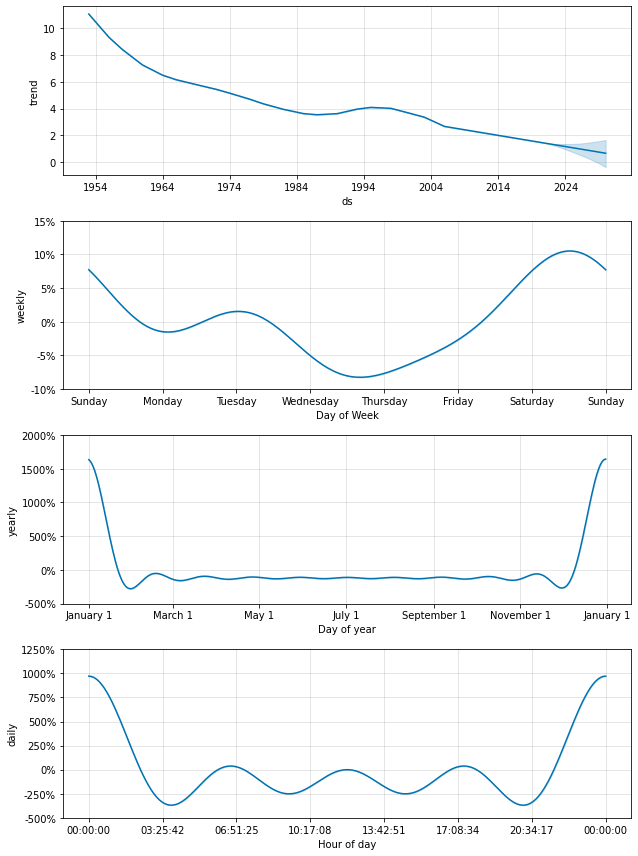

In [54]:
fig = final_model.plot_components(tuned_forecast)

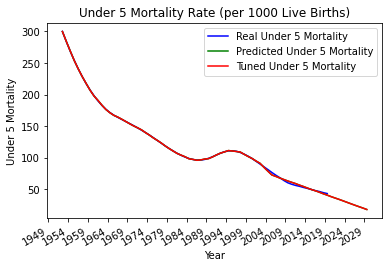

In [55]:
#visualize
# predicted = m.plot(forecast)

fig, ax = plt.subplots()
ax.plot(df['ds'],df['y'], color = 'blue', label = 'Real Under 5 Mortality')
ax.plot(forecast['ds'],forecast['yhat'], color = 'green', label = 'Predicted Under 5 Mortality')
ax.plot(tuned_forecast['ds'],tuned_forecast['yhat'], color = 'red', label = 'Tuned Under 5 Mortality')

# Major ticks every 6 months.
fmt_year = mdates.MonthLocator(interval = 60)
ax.xaxis.set_major_locator(fmt_year)

# Text in the x axis will be displayed in 'YYYY' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Rotates and right aligns the x labels, and moves the bottom of the axes up to make room for them.
fig.autofmt_xdate()
plt.xlabel('Year')
plt.legend()
plt.ylabel('Under 5 Mortality')
plt.title('Under 5 Mortality Rate (per 1000 Live Births)')
plt.show()

In [56]:
mape = mean_absolute_percentage_error(df['y'],tuned_forecast.loc[10:, 'yhat'])
print("MAPE",round(mape,4))


MAPE 27.6984
